# Sky Scanner Data Analyzing

# Analysis 1

### 컬럼소개
* Departure_city 출발지  
* Arrival_city 도착지  
* Collect_Time 데이터 수집시점  
* Target_Time 출발일  
* MinPrice 가격  
* QuoteDateTime 데이터 갱신날짜  

데이터 갱신날짜와 데이터 수집시점이 다른 이유는 수집한 데이터가 실시간 갱신되는 데이터가 아니고, 가장 최근에 고객이 검색한 데이터를 캐싱해놓고 사용하기 때문이다. 갱신시점으로 데이터를 수집하면 보다 정확하긴 하지만 비어있는 날짜가 많을 것이고, 수집시점기준으로 데이터를 분석하면 정확하진 않지만 빈구석은 없을 것이다.

In [1]:
import pandas as pd
import warnings
from matplotlib import font_manager, rc
import matplotlib as plt

rc('font', family= 'LG PC')
warnings.filterwarnings('ignore')
data = pd.read_csv('hkg_sela.csv')

### 분석요소
데이터를 살펴본결과, 여러 도시로 향하는 루트가 있었다. 우리는 우선 HKG에서 SELA로 가는 하나의 경우부터 살펴보려고 한다. 관심 대상으로는 어떤 것들이 있을 것인지 정리해 보았다.

1. 월별 Target_Time에 따라 가격변동의 패턴은 어떠한가?
2. 요일에 따른 가격의 변동이 있는가?
3. 수집한 날짜, 출발일, 가격에는 어떤 상관관계가 있는가?

# Feature Engineering

### 1. 필요없는 행을 제거, 데이터 범위 축소(HKG > SELA)

In [2]:
data.shape

(3334533, 7)

In [3]:
data.columns

Index(['Unnamed: 0', 'Departure_city', 'Arrival_city', 'Collect_Time',
       'Target_Time', 'MinPrice', 'QuoteDateTime'],
      dtype='object')

In [4]:
data = data.drop(['Unnamed: 0'], axis=1)

In [5]:
data.columns = ['출발지', '도착지', '데이터 수집시점', '출발일', '최소가격', '데이터 갱신날짜']

In [6]:
HS_data = data[(data['출발지'] == 'HKG') & (data['도착지'] == 'SELA')]

In [7]:
HS_data.head()

,출발지,도착지,데이터 수집시점,출발일,최소가격,데이터 갱신날짜
0,HKG,SELA,2017-09-28,2018-03-01,201206.0,2017-09-26T07:46:03
1,HKG,SELA,2017-09-28,2018-03-02,95866.0,2017-09-28T08:44:18
2,HKG,SELA,2017-09-28,2018-03-03,248538.0,2017-09-26T07:24:04
3,HKG,SELA,2017-09-28,2018-03-04,118799.0,2017-09-28T01:19:33
4,HKG,SELA,2017-09-28,2018-03-05,95866.0,2017-09-28T11:48:05


In [8]:
HS_data.shape

(29666, 6)

In [9]:
HS_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29666 entries, 0 to 3311241
Data columns (total 6 columns):
출발지         29666 non-null object
도착지         29666 non-null object
데이터 수집시점    29666 non-null object
출발일         29666 non-null object
최소가격        28414 non-null float64
데이터 갱신날짜    28414 non-null object
dtypes: float64(1), object(5)
memory usage: 1.6+ MB


In [10]:
HS_data.isnull().sum()

출발지            0
도착지            0
데이터 수집시점       0
출발일            0
최소가격        1252
데이터 갱신날짜    1252
dtype: int64

* 데이터를 살펴본결과(생략) 하나의 데이터 수집시점에 중복된 출발일은 없는 것 같고, 최소가격과 데이터 갱신날짜가 Null인 데이터가 1252개가 존재한다. 이에 대한 처리 방안이 필요할 것 같다.

### 2. 날짜 문자열을 datetime형식으로 바꾸고 메소드 활용하기

In [11]:
HS_data['데이터 수집시점'] = pd.to_datetime(HS_data['데이터 수집시점'])
HS_data['출발일'] = pd.to_datetime(HS_data['출발일'])
HS_data['데이터 갱신날짜'] = pd.to_datetime(HS_data['데이터 갱신날짜'])

### 3. 컬럼 추가(출발월)

In [12]:
HS_data['출발월'] = HS_data['출발일'].dt.month
# HS_data.rename(columns={'month':'출발월'}, inplace=True)

In [13]:
HS_data.head()

,출발지,도착지,데이터 수집시점,출발일,최소가격,데이터 갱신날짜,출발월
0,HKG,SELA,2017-09-28,2018-03-01,201206.0,2017-09-26 07:46:03,3
1,HKG,SELA,2017-09-28,2018-03-02,95866.0,2017-09-28 08:44:18,3
2,HKG,SELA,2017-09-28,2018-03-03,248538.0,2017-09-26 07:24:04,3
3,HKG,SELA,2017-09-28,2018-03-04,118799.0,2017-09-28 01:19:33,3
4,HKG,SELA,2017-09-28,2018-03-05,95866.0,2017-09-28 11:48:05,3


### 4. 필요없는 행을 제거

* 데이터 수집시점보다 출발일이 빠르면 가격데이터는 null값을 가지는 것을 확인 하였다.  
* 예측을 해야하는 시점에서 이러한 데이터가 쓸모가 없을 것 같아 삭제하였다.
* 삭제하고 난 후에도 Null값이 126개가 남아있는 것을 볼 수 있다.

In [14]:
HS_data[(HS_data['데이터 수집시점']) > (HS_data['출발일'])]['최소가격'].shape

(1126,)

In [15]:
HS_data = HS_data[HS_data['데이터 수집시점'] <= HS_data['출발일']]
HS_data.isnull().sum()

출발지           0
도착지           0
데이터 수집시점      0
출발일           0
최소가격        126
데이터 갱신날짜    126
출발월           0
dtype: int64

### 5. 컬럼 추가 - 출발요일
* monday - 0 sunday - 6

In [16]:
HS_data['출발요일'] = HS_data['출발일'].dt.dayofweek
HS_data.head(5)

,출발지,도착지,데이터 수집시점,출발일,최소가격,데이터 갱신날짜,출발월,출발요일
0,HKG,SELA,2017-09-28,2018-03-01,201206.0,2017-09-26 07:46:03,3,3
1,HKG,SELA,2017-09-28,2018-03-02,95866.0,2017-09-28 08:44:18,3,4
2,HKG,SELA,2017-09-28,2018-03-03,248538.0,2017-09-26 07:24:04,3,5
3,HKG,SELA,2017-09-28,2018-03-04,118799.0,2017-09-28 01:19:33,3,6
4,HKG,SELA,2017-09-28,2018-03-05,95866.0,2017-09-28 11:48:05,3,0


### 6. 데이터 수집시점 컬럼 수정과 데이터 갱신날짜열 삭제

* 데이터 갱신날짜가 있는경우 데이터 수집시점보다 데이터 갱신날짜를 쓰는 것이 좀더 정확한 예측을 할 수 있다.
* 데이터 수집시점을 데이터 갱신날짜 열로 대체하되, null값이면 그대로 쓴다. 

In [17]:
import numpy as np
HS_data['데이터 갱신날짜'] = np.where(pd.notnull(HS_data['데이터 갱신날짜']) == True, HS_data['데이터 갱신날짜'], HS_data['데이터 수집시점'])

In [18]:
HS_data['데이터 갱신날짜'].isnull().sum()

0

In [19]:
HS_data['데이터 수집시점'] = HS_data['데이터 갱신날짜']

In [20]:
HS_data.drop('데이터 갱신날짜', axis=1, inplace=True)

In [21]:
HS_data.head()

,출발지,도착지,데이터 수집시점,출발일,최소가격,출발월,출발요일
0,HKG,SELA,2017-09-26 07:46:03,2018-03-01,201206.0,3,3
1,HKG,SELA,2017-09-28 08:44:18,2018-03-02,95866.0,3,4
2,HKG,SELA,2017-09-26 07:24:04,2018-03-03,248538.0,3,5
3,HKG,SELA,2017-09-28 01:19:33,2018-03-04,118799.0,3,6
4,HKG,SELA,2017-09-28 11:48:05,2018-03-05,95866.0,3,0


### 7. 컬럼 추가 - 날짜차이

In [22]:
HS_data['날짜차이'] = HS_data['출발일'] - HS_data['데이터 수집시점']
HS_data.head(5)

,출발지,도착지,데이터 수집시점,출발일,최소가격,출발월,출발요일,날짜차이
0,HKG,SELA,2017-09-26 07:46:03,2018-03-01,201206.0,3,3,155 days 16:13:57
1,HKG,SELA,2017-09-28 08:44:18,2018-03-02,95866.0,3,4,154 days 15:15:42
2,HKG,SELA,2017-09-26 07:24:04,2018-03-03,248538.0,3,5,157 days 16:35:56
3,HKG,SELA,2017-09-28 01:19:33,2018-03-04,118799.0,3,6,156 days 22:40:27
4,HKG,SELA,2017-09-28 11:48:05,2018-03-05,95866.0,3,0,157 days 12:11:55


In [23]:
HS_data['날짜차이'] = HS_data['날짜차이'].dt.days

In [24]:
HS_data.head(5)

,출발지,도착지,데이터 수집시점,출발일,최소가격,출발월,출발요일,날짜차이
0,HKG,SELA,2017-09-26 07:46:03,2018-03-01,201206.0,3,3,155
1,HKG,SELA,2017-09-28 08:44:18,2018-03-02,95866.0,3,4,154
2,HKG,SELA,2017-09-26 07:24:04,2018-03-03,248538.0,3,5,157
3,HKG,SELA,2017-09-28 01:19:33,2018-03-04,118799.0,3,6,156
4,HKG,SELA,2017-09-28 11:48:05,2018-03-05,95866.0,3,0,157


In [25]:
HS_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28540 entries, 0 to 3311241
Data columns (total 8 columns):
출발지         28540 non-null object
도착지         28540 non-null object
데이터 수집시점    28540 non-null datetime64[ns]
출발일         28540 non-null datetime64[ns]
최소가격        28414 non-null float64
출발월         28540 non-null int64
출발요일        28540 non-null int64
날짜차이        28540 non-null int64
dtypes: datetime64[ns](2), float64(1), int64(3), object(2)
memory usage: 2.0+ MB


### 8. 최소가격의 Null값 채우기
* Null값은 해당 값이 있는 열의 출발일에 해당하는 최소가격 중앙값으로 채운다.

In [26]:
HS_data['최소가격'].fillna(HS_data.groupby('출발일')['최소가격'].transform('median'), inplace=True)

In [27]:
HS_data['최소가격'].isnull().sum()

2

* 해당 Target_Time에 대한 데이터가 하나 뿐이어서 평균값이 존재하지 않는 두가지 에 대하여 전체가격의 중앙값을 적용
* 그 결과 모든 Null값이 사라졌다.

In [28]:
HS_data['최소가격'].fillna(HS_data['최소가격'].median(), inplace=True)

In [29]:
HS_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28540 entries, 0 to 3311241
Data columns (total 8 columns):
출발지         28540 non-null object
도착지         28540 non-null object
데이터 수집시점    28540 non-null datetime64[ns]
출발일         28540 non-null datetime64[ns]
최소가격        28540 non-null float64
출발월         28540 non-null int64
출발요일        28540 non-null int64
날짜차이        28540 non-null int64
dtypes: datetime64[ns](2), float64(1), int64(3), object(2)
memory usage: 2.0+ MB


### Note

* 요일별 그래프에서 왜 전체 요일이 나오지 않는가?
* 예측을 정확하게 하려면 어떤 Feature Engineering이 필요할까?
* 예측을 하기위한(ex. up/down) 컬럼이 없는데 이것은 만들어 줘야 하는 것인가?
* 날짜의 차이 외에 어떤 부분이 있을까?
* 좀더 정확한 시각화를 위해 그래프의 MinPrice범위를 통일할 필요가 있다.
* 이상치를 제거해줄 필요가 있을 것 같다.

# Day2 
Focus on Visualization

* 날짜별 그래프가 자주 쓰일 것이다.
* 데이터 수집시점에 좀더 초점을 맞추어서 시각화를 해보는 것이 좋다.
* x축을 출발 몇 일전(날짜차이)으로 해서 여러 날짜에 대한 그래프가 그려질 수 있도록 한다. 몇일 간의 데이터를 입력시킬 수 있도록.
* 파라미터 2개의 함수 생성 데이터프레임과 검색 날짜를 인수로 받는다.

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import font_manager, rc

%matplotlib inline
sns.set()

In [31]:
result = pd.DataFrame(HS_data[HS_data['날짜차이'] <= 30]['출발일'].value_counts()).reset_index()
result.columns=['출발일', '데이터 수']


In [32]:
def cost_variation(df, find_date, date_range=None):
    rc('font', family= 'LG PC')
    if date_range == None:
        base = df[(df['출발일'] == find_date)]
    else:
        base = df[(df['출발일'] == find_date) & (df['날짜차이'] <= date_range)]
    if base.size == 0:
        print(find_date, '에 해당하는 데이터가 없습니다.')
        print(date_range, '일 전까지의 데이터가 존재하는 출발일은 다음과 같습니다.')
        result = pd.DataFrame(df[df['날짜차이'] <= date_range]['출발일'].value_counts()).reset_index()
        result.columns=['출발일', '데이터 수']
        result.sort_values(by=['출발일'], inplace=True)
        result['출발일'] = result['출발일'].dt.date
        
        fig, ax = plt.subplots()
        fig.set_size_inches(40, 10)
        plt.sca(ax)
        plt.xticks(rotation=90, ha='right')
        ax.set(title='출발일에 따른 데이터 수')
        sns.barplot(data=result, x='출발일', y='데이터 수', ax=ax)
        return
    
    print(find_date, '에는 최대 ', df[df['출발일'] == find_date]['날짜차이'].max(), '일 전까지의 데이터가 있습니다.')
    fig, ax = plt.subplots()
    fig.set_size_inches(25, 10)
    
    plt.sca(ax)
    plt.xticks(rotation=30, ha='right')
            
    ax.set(title='데이터 수집시점에 따른 ' + find_date + ' 의 가격변동')
    sns.barplot(data=base, x='날짜차이', y='최소가격', ax=ax)
    

2018-05-03 에 해당하는 데이터가 없습니다.
15 일 전까지의 데이터가 존재하는 출발일은 다음과 같습니다.


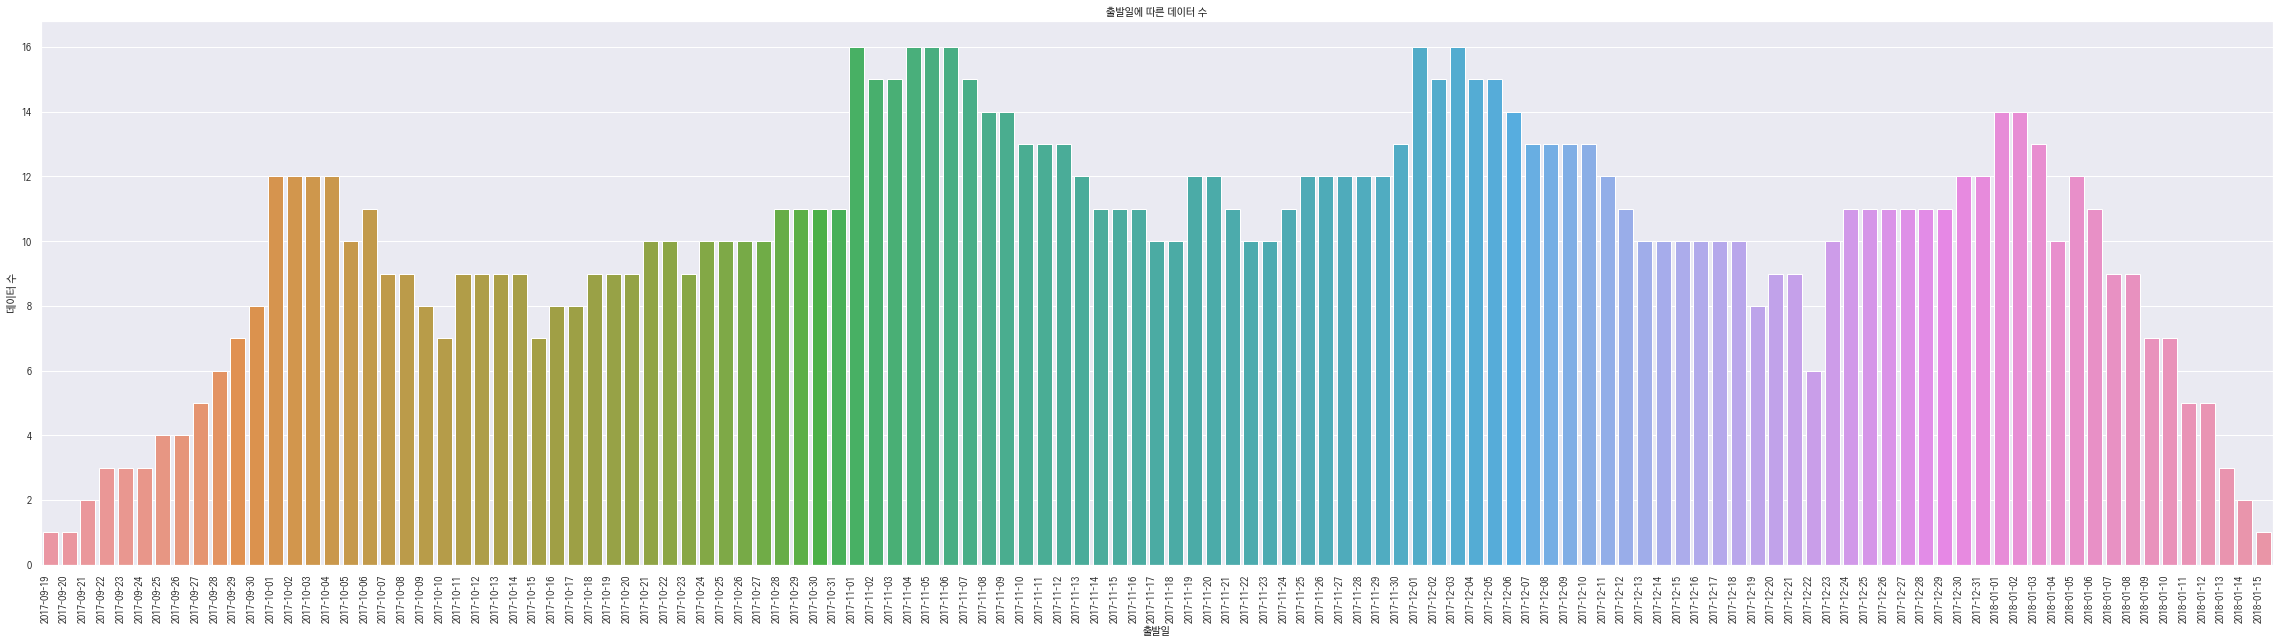

In [36]:
cost_variation(HS_data, '2018-05-03', 15)

In [34]:
len(HS_data['출발일'].unique())

347

In [35]:
len(HS_data[HS_data['날짜차이'] <= 70]['출발일'].unique())

172

### Note
* 시각화 완료.
* 출발일과 가까운 시일 내에 수집한 데이터가 얼마 없다.
* 데이터가 분석하기에 부족한 것은 아닌지?
* 표를 구매하는데 ~일 전에 예약할 때 가격은 어떨 것인가? 추후 어떻게 변동할 것인가?
* 출발일 직전에 보통 가격이 낮다(떨이표)